In [1]:
pip install modAL

In [2]:
import numpy as np
from sklearn.decomposition import PCA
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from IPython import display
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
X, y = datasets.load_breast_cancer(return_X_y=True)

In [4]:
pca = PCA(n_components=2, random_state = 42)
transformed_data = pca.fit_transform(X = X)

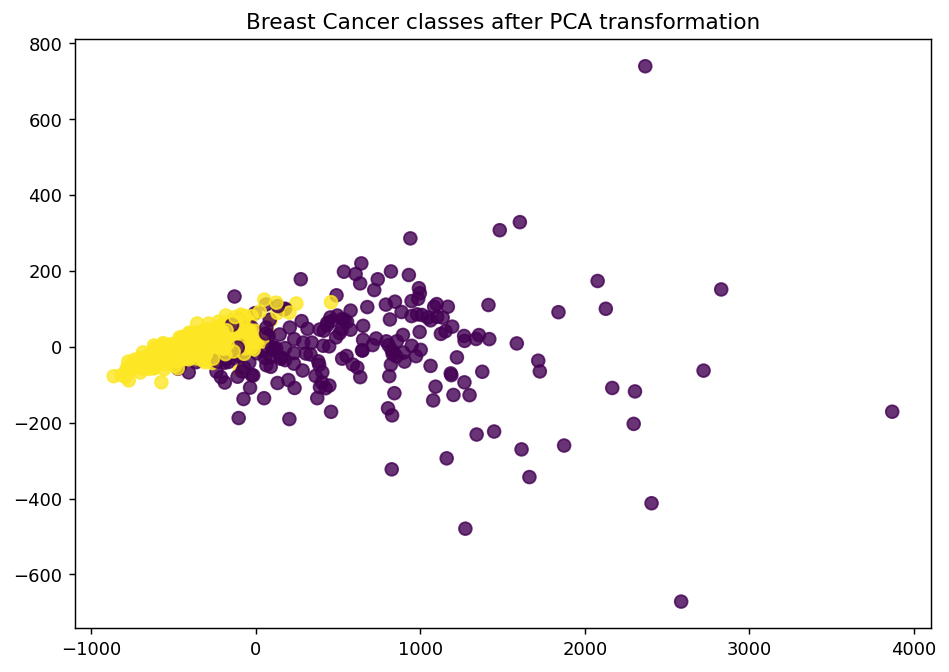

In [5]:
x_component, y_component = transformed_data[:, 0], transformed_data[:, 1]

plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y, cmap='viridis', s=50, alpha=8/10)
plt.title('Breast Cancer classes after PCA transformation')
plt.show()

In [6]:
# Isolate examples for the labeled dataset.
n_labeled_examples = X.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X[training_indices]
y_train = y[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X, training_indices, axis=0)
y_pool = np.delete(y, training_indices, axis=0)

ACTIVE LEARNING - POOL-BASED SAMPLING


In [7]:
# Specify the core estimator along with it's active learning model.
rfc = RandomForestClassifier(n_estimators=10)
learner = ActiveLearner(estimator=rfc, X_training=X_train, y_training=y_train)

# Isolate the data we'll need for plotting.
predictions = learner.predict(X)
is_correct = (predictions == y)

predictions

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

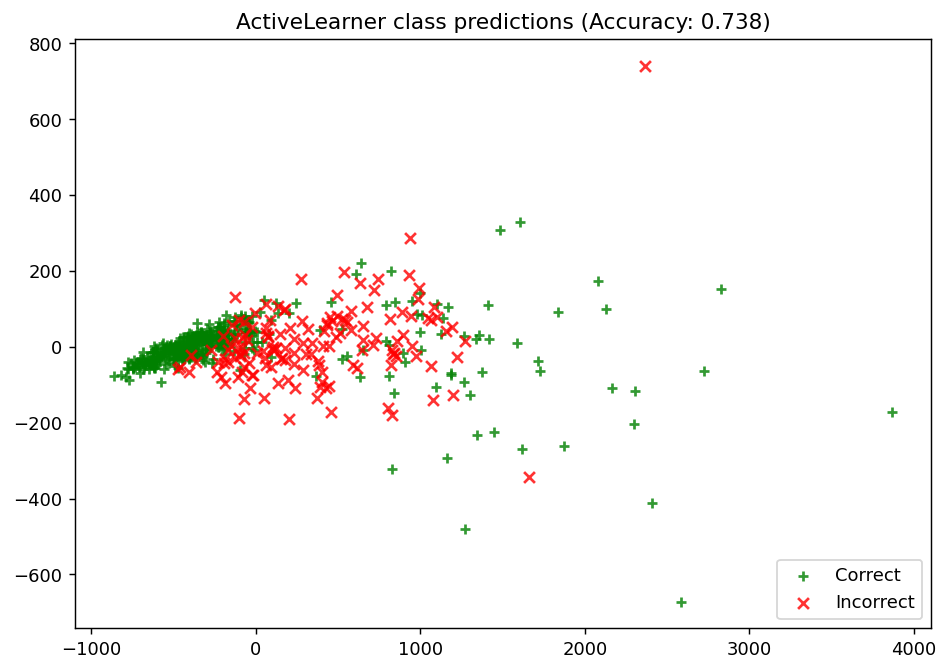

In [8]:
# Record learner's score on the raw data.
unqueried_score = learner.score(X, y)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

Update our model by pool-based sampling on “unlabeled” dataset

In [9]:
N_QUERIES = 50
performance_history = [unqueried_score]

# Allow model to query the unlabeled dataset for the most
# informative points according to the query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach ActiveLearner model the record it has requested.
  X_p, y_p = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X_p, y=y_p)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report model's accuracy.
  model_accuracy = learner.score(X, y)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.8699
Accuracy after query 2: 0.8471
Accuracy after query 3: 0.7996
Accuracy after query 4: 0.9192
Accuracy after query 5: 0.5975
Accuracy after query 6: 0.7153
Accuracy after query 7: 0.7311
Accuracy after query 8: 0.8981
Accuracy after query 9: 0.8049
Accuracy after query 10: 0.8735
Accuracy after query 11: 0.8524
Accuracy after query 12: 0.9033
Accuracy after query 13: 0.7540
Accuracy after query 14: 0.6907
Accuracy after query 15: 0.7522
Accuracy after query 16: 0.7786
Accuracy after query 17: 0.8471
Accuracy after query 18: 0.7786
Accuracy after query 19: 0.8664
Accuracy after query 20: 0.7821
Accuracy after query 21: 0.8629
Accuracy after query 22: 0.8594
Accuracy after query 23: 0.8576
Accuracy after query 24: 0.8787
Accuracy after query 25: 0.8524
Accuracy after query 26: 0.8524
Accuracy after query 27: 0.8401
Accuracy after query 28: 0.8559
Accuracy after query 29: 0.8576
Accuracy after query 30: 0.8682
Accuracy after query 31: 0.8875
Accuracy after qu

Evaluate model’s performance

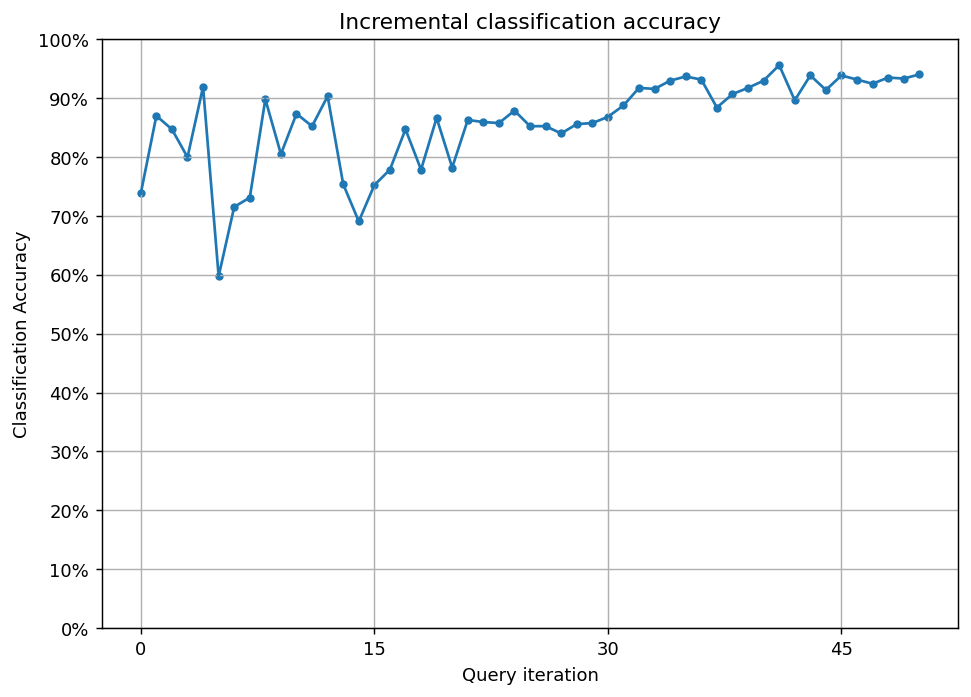

In [10]:
# Plot the performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

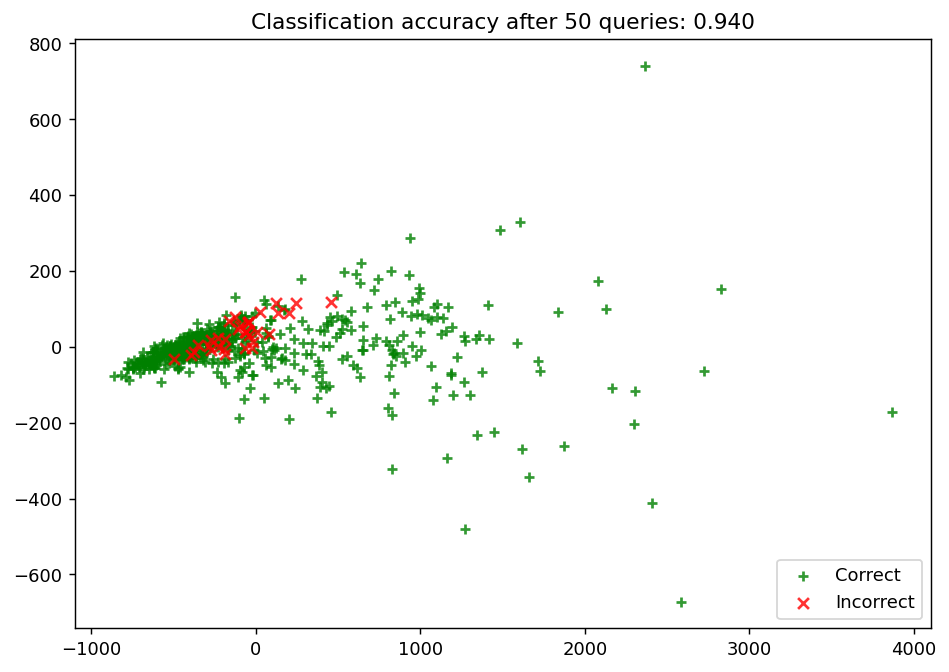

In [11]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X)
is_correct = (predictions == y)

# Plot updated classification results once we've trained the learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()